In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

data_file = "/home/awias/data/Summerschool_2025/metadata_more.csv"

# Load your CSV file
df = pd.read_csv(data_file)

# Only keep the records where the substring 'train' is in filename_index
df = df[df['filename_index'].str.contains('train', na=False)].copy()

# Remove rows where taxonID_index is missing (since it's our target)
df = df.dropna(subset=['taxonID_index']).copy()

# Remove 'eventDate' column
df = df.drop(columns=['eventDate'], errors='ignore')

# Remove rows where at least two of the specified columns are NaN
cols_to_check = ['Habitat', 'Latitude', 'Longitude', 'Substrate']
df = df[df[cols_to_check].isnull().sum(axis=1) < 2].copy()

In [19]:
# Encode categorical variables
label_encoders = {}
categorical_features = ['Habitat', 'Substrate']

for col in categorical_features:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    
# Prepare final feature matrix (without date features)
feature_cols_final = ['Habitat_encoded', 'Latitude', 'Longitude', 'Substrate_encoded']

X = df[feature_cols_final]
y = df['taxonID_index']


In [20]:
# Encode target variable if it's categorical
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y.astype(str))

print(f"\nNumber of unique target classes: {len(target_encoder.classes_)}")
print(f"Target classes: {target_encoder.classes_[:10]}...")  # Show first 10

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Train XGBoost model with GPU support
print("\nTraining XGBoost model on GPU...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss' if len(np.unique(y_encoded)) > 2 else 'logloss',
    tree_method='gpu_hist',  # Use GPU for training
    gpu_id=0,  # Use first GPU
    early_stopping_rounds=10
)


Number of unique target classes: 181
Target classes: ['0.0' '1.0' '10.0' '100.0' '101.0' '102.0' '103.0' '104.0' '105.0'
 '106.0']...

Training set size: (2537, 4)
Test set size: (635, 4)

Training XGBoost model on GPU...


In [21]:
# Add validation set for early stopping
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

xgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val, y_val)],
    verbose=True
)

/home/awias/anaconda3/envs/standard/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:50:19] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  self.starting_round = model.num_boosted_rounds()
/home/awias/anaconda3/envs/standard/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:50:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:5.12577
[1]	validation_0-mlogloss:5.06117
[2]	validation_0-mlogloss:5.00558
[3]	validation_0-mlogloss:4.95554
[4]	validation_0-mlogloss:4.91063
[5]	validation_0-mlogloss:4.86931
[6]	validation_0-mlogloss:4.83326
[7]	validation_0-mlogloss:4.80228
[8]	validation_0-mlogloss:4.77165
[9]	validation_0-mlogloss:4.73966
[10]	validation_0-mlogloss:4.71541
[11]	validation_0-mlogloss:4.69120
[12]	validation_0-mlogloss:4.67275
[13]	validation_0-mlogloss:4.65190
[14]	validation_0-mlogloss:4.63246
[15]	validation_0-mlogloss:4.61687
[16]	validation_0-mlogloss:4.60347
[17]	validation_0-mlogloss:4.59089
[18]	validation_0-mlogloss:4.58002
[19]	validation_0-mlogloss:4.56945
[20]	validation_0-mlogloss:4.55603
[21]	validation_0-mlogloss:4.54720
[22]	validation_0-mlogloss:4.54113
[23]	validation_0-mlogloss:4.53164
[24]	validation_0-mlogloss:4.52659
[25]	validation_0-mlogloss:4.52162
[26]	validation_0-mlogloss:4.51774
[27]	validation_0-mlogloss:4.51476
[28]	validation_0-mlogloss:4.5

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,10
,enable_categorical,False
,eval_metric,'mlogloss'


In [24]:
# Make predictions
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [25]:
# Model accuracy
print(f"\nModel Accuracy: {accuracy:.3f}")


Model Accuracy: 0.175



Feature Importance Ranking:
             feature  importance
3  Substrate_encoded    0.433359
0    Habitat_encoded    0.230660
1           Latitude    0.169884
2          Longitude    0.166097


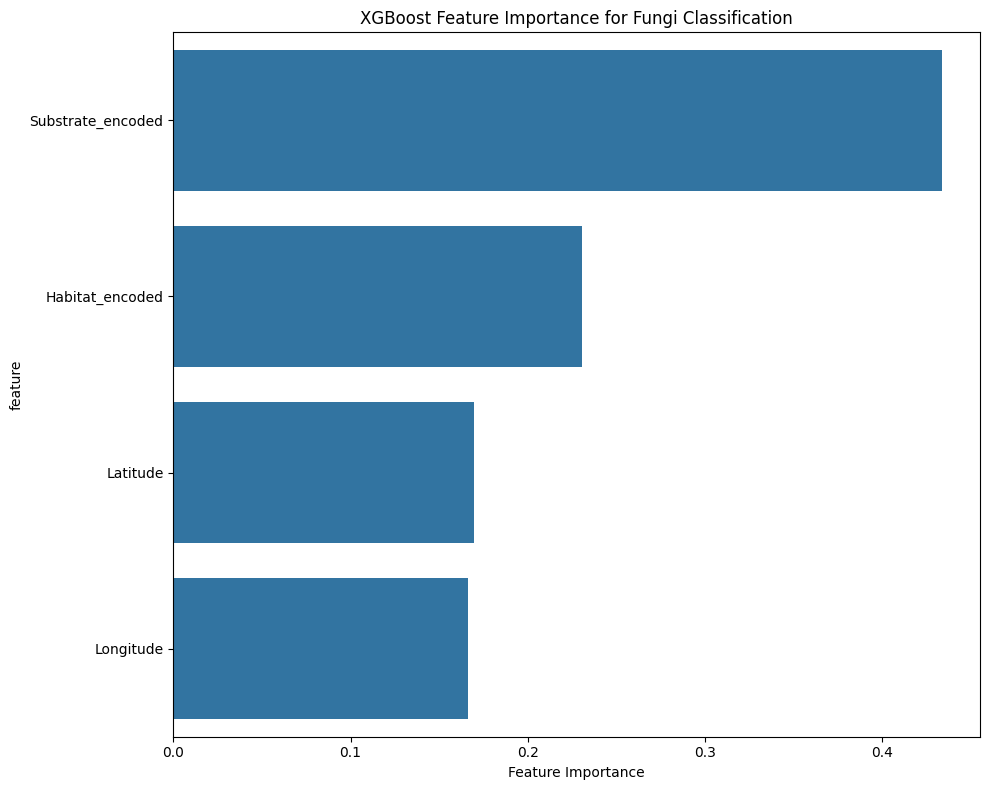

In [26]:
# Feature Importance Analysis
feature_importance = xgb_model.feature_importances_
feature_names = X.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, y='feature', x='importance')
plt.title('XGBoost Feature Importance for Fungi Classification')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()